# Fine-Tuning All-MiniLM

This notebook showcases the finetuning of the "All-MiniLM-L6-v2" model used to solve the problem of entity alignment/merging. The model has a relatively small size with a fast inference and is proficient in identifying similarities between sentences. The dataset on which it was trained was generated through OpenAi's gpt4 model that focuses on the fields of economy and finance, it covers multiples subcategories. Lastly, a comparison between the finetuned model and the base model is provided. For further steps a richer and more diversified dataset is required given the model's performance through various architectures.

Prompt used to generate the dataset:
"Provide a dataset in csv format containing 3 collumns: Triplet 1, Triplet 2, Label (can be 0 or 1) that will define wether two triplets should be merged or not in knowledge graphs, this means that the triplets provide the same/similar information but using different semantics,if either one of the triplets provide an additional information that would be relevant in the context of a knowledge graph, then no merging is required. The proportion of data points labeled 0 and 1 is 50%/50%. provide 40 entries. The field of the triplets should be : (chosen-field). Provide the list of triplets directly."

here are the fields already covered in the dataset:
- Économie de l'Environnement et des Ressources Naturelles:
  
Gestion des ressources naturelles, Économie de l'énergie, Pollution et politiques environnementales, Changement climatique, Économie de l'eau, Économie de la biodiversité, Durabilité et développement durable, Économie des déchets, Évaluation environnementale, Commerce et environnement

- Économie du Travail:
  
Marché du travail, Politiques de l'emploi, Syndicalisme, Éducation et marché du travail, Discrimination sur le marché du travail, Migration de travail, Salaire et rémunération, Sécurité de l'emploi, Productivité du travail, Économie du genre et du travail

- Économie Publique:
  
Finances publiques, Fiscalité, Dépense publique, Redistribution des revenus, Politiques sociales, Économie de la santé publique, Éducation publique, Économie des collectivités locales, Théorie du choix public, Politiques de régulation

Additional remarks:
Specifying the fields for a given set of data entries is crucial to avoid duplicates that might start to emerge after a certain number of exchanges

Load the necessary librairies

In [1]:
%%capture
!pip install torch transformers sentence-transformers

In [2]:
from transformers import AutoModel, AutoTokenizer
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.nn.functional import cosine_similarity
from torch.nn.functional import softmax
import numpy as np
import os

/home/blatrie/travail/KG_generation_2.0/my_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data pre-processing

In [3]:
df = pd.read_csv('data/all-mini-triplets.csv')

def preprocess_triplet(triplet):
    return triplet.replace(',', ' ') + '.'

df['Triplet 1'] = df['Triplet 1'].apply(preprocess_triplet)
df['Triplet 2'] = df['Triplet 2'].apply(preprocess_triplet)

train_df, val_df = train_test_split(df, test_size=0.1)
train_df.info()
print()
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3044 entries, 2080 to 2133
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Triplet 1  3044 non-null   object
 1   Triplet 2  3044 non-null   object
 2   Label      3044 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 95.1+ KB

<class 'pandas.core.frame.DataFrame'>
Index: 339 entries, 2905 to 482
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Triplet 1  339 non-null    object
 1   Triplet 2  339 non-null    object
 2   Label      339 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 10.6+ KB


Defining the Model and Dataset classes

In [22]:
class TripletClassifier(nn.Module):
    def __init__(self, pretrained_model_name):
        super(TripletClassifier, self).__init__()
        self.encoder = AutoModel.from_pretrained(pretrained_model_name)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        # Couches denses intermédiaires
        self.dense1 = nn.Linear(self.encoder.config.hidden_size, 256)
        self.dense2 = nn.Linear(256, 128)
        self.dense3 = nn.Linear(128, 64)
        self.dense4 = nn.Linear(64, 32)
        self.dense5 = nn.Linear(32, 32)
        
        self.dropout = nn.Dropout(0.3)

        # La couche de classification finale
        self.classifier = nn.Linear(32, 1)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        # Passer à travers l'encodeur
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]  # Représentation de la séquence (CLS token)

        # Passer à travers les couches denses
        x = self.dense1(pooled_output)
        x = self.relu(x)
        x = self.dense2(x)
        x = self.relu(x)
        x = self.dense3(x)
        x = self.relu(x)

        #x = self.dropout(x)

        x = self.dense4(x)
        x = self.relu(x)
        x = self.dense5(x)
        x = self.relu(x)

        #x = self.dropout(x)

        # Passer à travers la couche de classification
        logits = self.classifier(x)
        logits = logits.squeeze(-1)  # Squeeze pour obtenir un vecteur 1D
        
        return logits

In [5]:
class TripletDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        inputs = self.tokenizer(row['Triplet 1'], row['Triplet 2'], padding='max_length', truncation=True, max_length=128, return_tensors='pt')
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}
        label = torch.tensor(float(row['Label']))
        return inputs, label

Loading model, tokenizer

In [23]:
%%capture
model_name_1 = 'sentence-transformers/all-MiniLM-L6-v2'
model_name_2 = 'BAAI/bge-small-en-v1.5'
model_name_3 = 'BAAI/bge-large-en-v1.5'
model = TripletClassifier(model_name_2)
tokenizer = AutoTokenizer.from_pretrained(model_name_2)
train_dataset = TripletDataset(train_df, tokenizer)
val_dataset = TripletDataset(val_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = nn.BCEWithLogitsLoss()

In [13]:
bge = AutoModel.from_pretrained(model_name_2)
print(bge.config.hidden_size)

384


Training And Validation functions

In [8]:
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0

    for inputs, labels in data_loader:
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = loss_fn(outputs, labels.float())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.round(torch.sigmoid(outputs)).squeeze()
        correct_predictions += torch.sum(preds == labels).item()

    avg_loss = total_loss / len(data_loader)
    avg_accuracy = correct_predictions / (len(data_loader.dataset))
    return avg_loss, avg_accuracy


def validate_epoch(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    predictions = []
    actuals = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            outputs = model(**inputs)
            loss = loss_fn(outputs, labels.float())
            total_loss += loss.item()

            preds = torch.round(torch.sigmoid(outputs))
            predictions.extend(preds.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(actuals, predictions)
    return avg_loss, accuracy

Training Loop

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

loss_history = []
acc_history = []
val_loss_history = []
val_acc_history = []

# Training loop
epochs = 10
for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimizer, device)
    val_loss, val_accuracy = validate_epoch(model, val_loader, loss_fn, device)

    loss_history.append(train_loss)
    acc_history.append(train_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_accuracy)

100%|██████████| 10/10 [02:09<00:00, 12.93s/it]


**Plot:** Loss

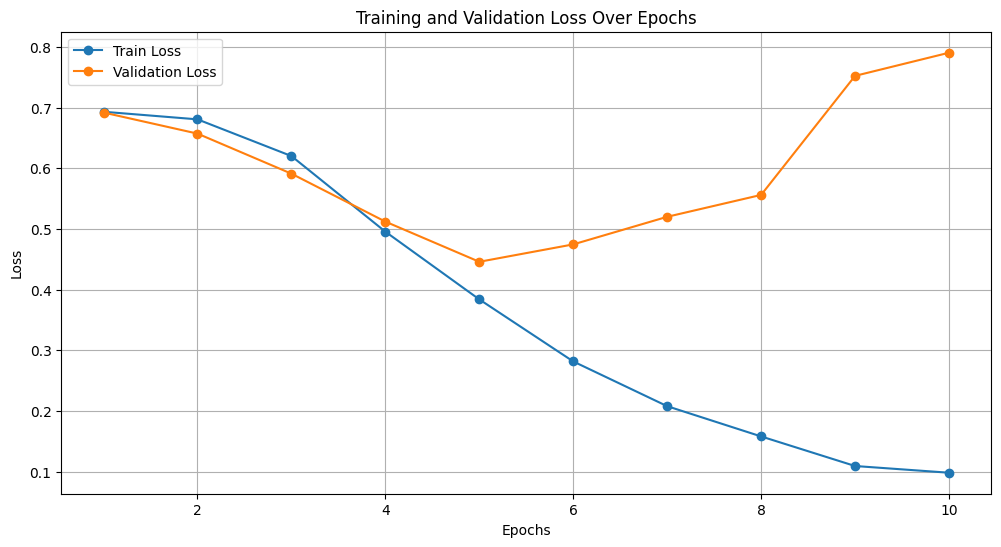

In [25]:
plt.figure(figsize=(12, 6))

plt.plot(range(1, epochs + 1), loss_history, label='Train Loss', marker='o')
plt.plot(range(1, epochs + 1), val_loss_history, label='Validation Loss', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot:** Accuracy

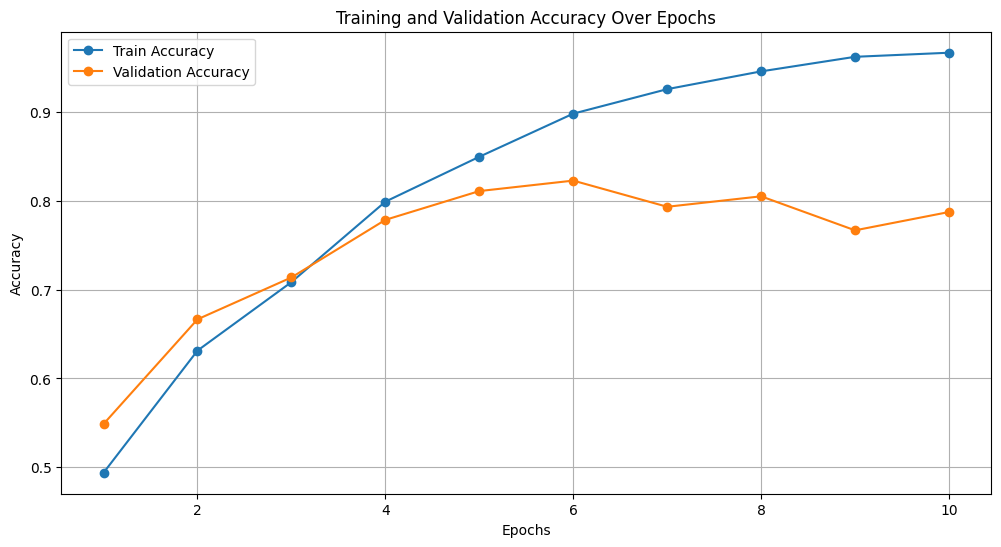

0.8230088495575221


In [26]:
plt.figure(figsize=(12, 6))

plt.plot(range(1, epochs + 1), acc_history, label='Train Accuracy', marker='o')
plt.plot(range(1, epochs + 1), val_acc_history, label='Validation Accuracy', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

print(np.max(val_acc_history))

In [11]:
print(acc_history)
print(val_acc_history)

[0.6484888304862023, 0.8212877792378449, 0.900131406044678, 0.9336399474375822, 0.9602496714848883, 0.9674770039421814, 0.9694480946123522, 0.9717477003942181, 0.9760183968462549, 0.9766754270696452]
[0.7669616519174042, 0.7846607669616519, 0.8112094395280236, 0.8141592920353983, 0.799410029498525, 0.8023598820058997, 0.7935103244837758, 0.775811209439528, 0.7905604719764012, 0.7964601769911505]


In [ ]:
# Chemin où sauvegarder le modèle
output_dir = "../models"
os.makedirs(output_dir, exist_ok=True)  # Crée le répertoire s'il n'existe pas
model_path = os.path.join(output_dir, "finetuned_all_mini.pth")

# Sauvegarde du modèle
torch.save(model, model_path)
print(f"Modèle sauvegardé à : {model_path}")

# Testing the Fine-Tuning

Testing set and base model loading

In [ ]:
%%capture
triplets = [
    ('Donald Trump initiated significant tax reforms', 'The U.S economy under Donald Trump saw major tax legislation'),
    ('John is a key software engineer at Apple', 'John contributes to Apple\'s innovation in technology'),
    ('Washington, D.C. hosts major economic conferences', 'Economic policies are often debated in the capital of the U.S'),
    ('Nikola Tesla\'s inventions greatly impacted the energy sector', 'Tesla\'s work laid the foundation for modern electrical engineering'),
    ('Carl Jung\'s theories influenced organizational psychology', 'Jungian principles are applied in business leadership and management'),
    ('Actor invests in tech startups', 'Actor\'s venture capital firm supports innovative tech companies'),
    ('Apple\'s headquarters in California is a hub for tech development', 'Apple\'s founding in California catalyzed the Silicon Valley boom'),
    ('Justin Johnson advocates for economic development in Ohio', 'Justin Johnson\'s policies aim to boost Ohio\'s economy'),
    ('Nikola Tesla\'s advancements in electromagnetism revolutionized industries', 'Tesla\'s discoveries contributed to economic growth in energy and manufacturing'),
]

base_model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2').to(device)

Similarity for fine-tuned model function

In [ ]:
def predict_similarity(model, tokenizer, sentence_pair, device):
    encoded_input = tokenizer.encode_plus(sentence_pair[0], sentence_pair[1], return_tensors='pt', truncation=True, padding=True).to(device)
    model.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(**encoded_input)
        prediction = torch.sigmoid(outputs).squeeze()
    return prediction.item()

Similarity for base model

In [ ]:
def compute_cosine_similarity(model, encodings, device):
    model.to(device)
    model.eval()
    similarities = []

    with torch.no_grad():
        for encoding in encodings:
            inputs = {k: v.to(device) for k, v in encoding.items()}
            outputs = model(**inputs)
            embeddings = outputs[1]
            similarity = cosine_similarity(embeddings[0], embeddings[1], dim=0)
            similarities.append(similarity.item())

    return similarities

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def cosine_similarity(embeddings1, embeddings2):
    return F.cosine_similarity(embeddings1.unsqueeze(0), embeddings2.unsqueeze(0))

Computing Similarities

In [ ]:
for triplet1, triplet2 in triplets:
    # Base model
    encoded_input = tokenizer([triplet1, triplet2], padding=True, truncation=True, return_tensors='pt').to(device)
    with torch.no_grad():
        basic_output = base_model(**encoded_input)
        basic_embeddings = mean_pooling(basic_output, encoded_input['attention_mask'])
    basic_similarity = cosine_similarity(basic_embeddings[0], basic_embeddings[1])
    fine_tuned_similarity = predict_similarity(model, tokenizer, (triplet1, triplet2), device)

    print(f"Pair\033[30m 1. \033[0m{triplet1},\033[30m 2. \033[0m{triplet2}")
    print(f"Basic Model      : \033[31m{np.round(basic_similarity.item(),3)}\033[0m")
    print(f"Fine-tuned Model : \033[34m{np.round(fine_tuned_similarity,3)}\033[0m\n")

# Comparison between Base Model and Fine-Tuned Model

Retrieving the test set and loading it in a Dataframe

In [ ]:
doc = 'https://josephbeasse.fr/all-mini-triplets-test.csv'

response_test = requests.get(doc)

if response_test.status_code == 200:
    with open('all-mini-triplets-test.csv', 'wb') as file:
        file.write(response_test.content)
        print("CSV Downloaded.")

test_df = pd.read_csv('all-mini-triplets-test.csv')

triplets_test = list(zip(test_df['Triplet 1'], test_df['Triplet 2']))
labels_test = test_df['Label'].values

Function to calculate accuracy of both models depending on a Threshold

In [ ]:
def calculate_accuracy(model, tokenizer, triplets, labels, device, threshold=0.8):
    correct_predictions = 0

    for idx, (triplet1, triplet2) in enumerate(triplets):
        encoded_input = tokenizer([triplet1, triplet2], padding=True, truncation=True, return_tensors='pt').to(device)
        with torch.no_grad():
            if model == base_model:
                ## Base model
                model_output = model(**encoded_input)
                embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
                similarity = cosine_similarity(embeddings[0], embeddings[1]).item()
            else:
                # Fine-tuned model
                similarity = predict_similarity(model, tokenizer, (triplet1, triplet2), device)

        prediction = 1 if similarity >= threshold else 0
        if prediction == int(labels[idx]):
            correct_predictions += 1

    accuracy = correct_predictions / len(triplets)
    return accuracy

Results

In [ ]:
# Dataset de validation car résultats pas ouf avec le test, pas spécialisé en finance
triplets_test = list(zip(val_df['Triplet 1'], val_df['Triplet 2']))
labels_test = val_df['Label'].values

In [ ]:
threshold = 0.8
base_model_accuracy = calculate_accuracy(base_model, tokenizer, triplets_test, labels_test, device, threshold=threshold)
fine_tuned_model_accuracy = calculate_accuracy(model, tokenizer, triplets_test, labels_test, device, threshold=threshold)

print(f"Base Model Accuracy      : \033[31m{base_model_accuracy:.3f}\033[0m")
print(f"Fine-tuned Model Accuracy: \033[34m{fine_tuned_model_accuracy:.3f}\033[0m")